In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.utils import resample
from PIL import UnidentifiedImageError  # Import UnidentifiedImageError
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load data with error handling for invalid image files
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            try:
                # Only load if it's a valid image file
                image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
                image_array = img_to_array(image)
                images.append(image_array)
                labels.append(label)
            except UnidentifiedImageError:
                print(f"UnidentifiedImageError: Could not load {image_path}, skipping.")
            except Exception as e:
                print(f"Error: {e} while loading {image_path}, skipping.")
    return np.array(images), np.array(labels)

folder_path = "datasets/Oral cancer Dataset 2.0"
images, labels = load_data(folder_path)

C:\Users\latia\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\101.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\200.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\273.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\317.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\328.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\407.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\450.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\455.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\481.jpeg, skipping.
UnidentifiedImageError: Could not load datasets/Oral cancer Dataset 2.0\cancer\485.jpeg, skipping.


In [3]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [4]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

In [5]:
# Define and compile the model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

In [8]:
model_EfficientNetB2 = Model(inputs=base_model.input, outputs=predictions)


In [9]:
model_EfficientNetB2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 260, 260, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 260, 260, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 260, 260, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 260, 260, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 261, 261, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 130, 130, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 130, 130, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 130, 130, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 130, 130, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 130, 130, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 130, 130, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 9,212,410 (35.14 MB)

 Trainable params: 1,443,841 (5.51 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.286786 to fit



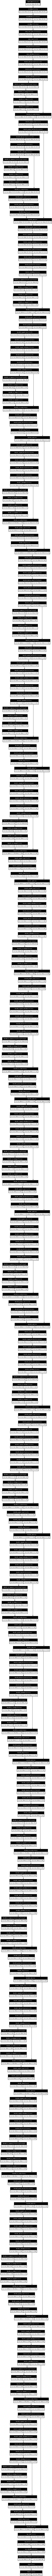

In [10]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(model_EfficientNetB2, to_file='./architecture/efficientnetb2_model.png', show_shapes=True, show_layer_names=True)

In [10]:
model_EfficientNetB2.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [12]:
checkpoint_filepath = './models/best_model_resnet3.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [13]:
# Train the model
history = model_EfficientNetB2.fit(
    x= X_train,
    y= y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7355 - loss: 0.4773 - precision: 0.7087 - recall: 0.7312
Epoch 1: val_accuracy improved from -inf to 0.89362, saving model to ./models/best_model_resnet3.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7393 - loss: 0.4724 - precision: 0.7130 - recall: 0.7354 - val_accuracy: 0.8936 - val_loss: 0.2769 - val_precision: 0.8438 - val_recall: 0.9419 - learning_rate: 0.0010
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9375 - loss: 0.1626 - precision: 0.9256 - recall: 0.9408
Epoch 2: val_accuracy improved from 0.89362 to 0.90426, saving model to ./models/best_model_resnet3.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9374 - loss: 0.1629 - precision: 0.9259 - recall: 0.9406 - val_accuracy: 0.9043 - val_loss: 0.2554 - val_precision: 0.8696 - val_recall: 0.9302 - learning_rate: 0.0010
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9499 - loss: 0.1293 - precision: 0.9437 - reca

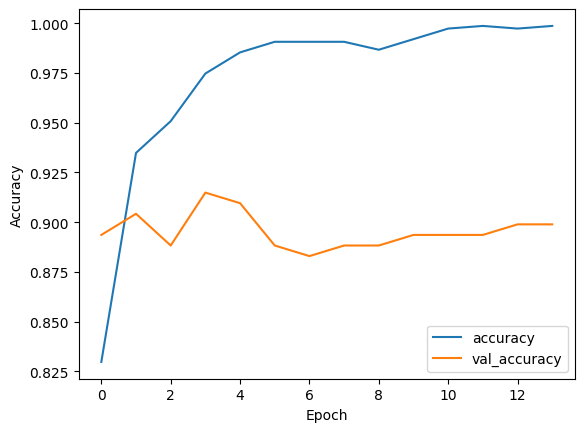

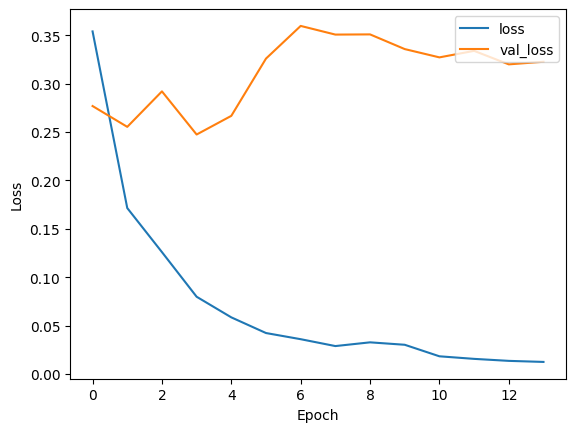

In [14]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [15]:
# Evaluate the model on the test set
evaluation =model_EfficientNetB2.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")
print(f"Test Precision: {evaluation[2]}")
print(f"Test Recall: {evaluation[3]}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9208 - loss: 0.2336 - precision: 0.9350 - recall: 0.8872
Test Loss: 0.24752168357372284
Test Accuracy: 0.914893627166748
Test Precision: 0.9268292784690857
Test Recall: 0.8837209343910217


In [16]:
# Make predictions on the test set
y_pred = (model_EfficientNetB2.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['Non Cancer', 'Cancer'])
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
              precision    recall  f1-score   support

  Non Cancer       0.91      0.94      0.92       102
      Cancer       0.93      0.88      0.90        86

    accuracy                           0.91       188
   macro avg       0.92      0.91      0.91       188
weighted avg       0.92      0.91      0.91       188



In [17]:
y_pred

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
    

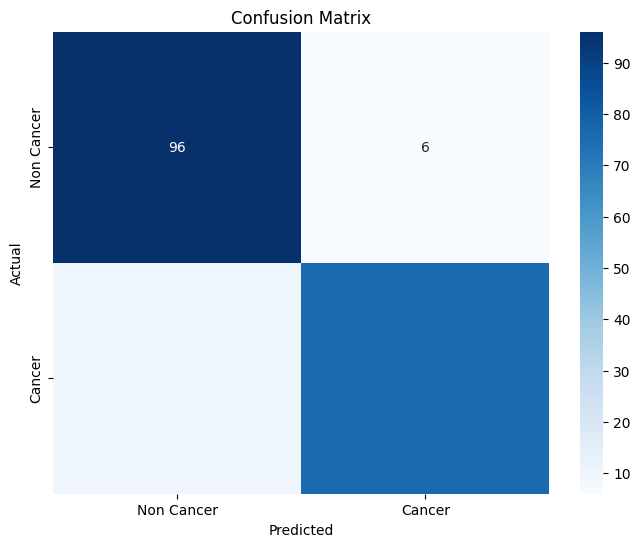

In [21]:
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Cancer', 'Cancer'], yticklabels=['Non Cancer', 'Cancer'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

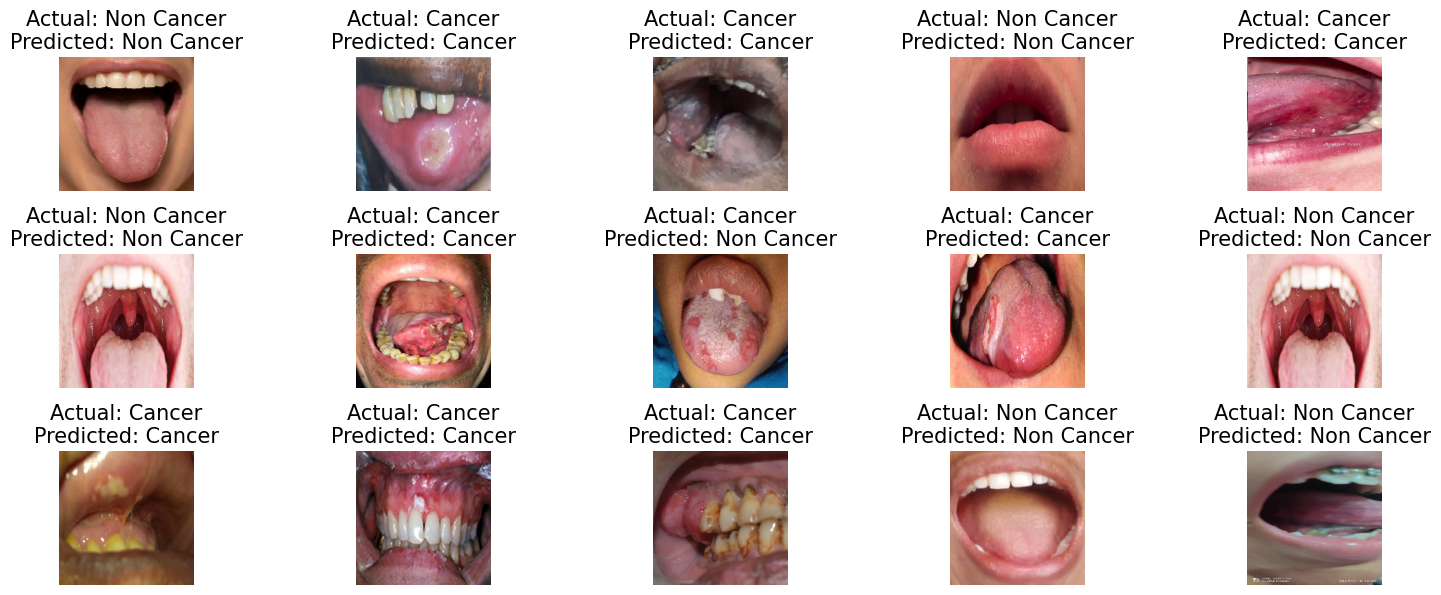

In [22]:
import matplotlib.pyplot as plt

def display_images_with_predictions(X_test, y_test, y_pred, num_images=10):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)  # Adjust the layout as needed
        plt.imshow(X_test[i].astype('uint8'))  # Convert to uint8 for correct display
        plt.axis('off')
        
        # Display actual and predicted labels
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if y_pred[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPredicted: {predicted}', fontsize=15)

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_images_with_predictions(X_test, y_test, y_pred, num_images=15)  # Display 15 images


In [19]:
def evaluate_model(model, new_data_path):
    new_images, new_labels = load_data(new_data_path)
    predictions = model.predict(new_images)
    predicted_classes = (predictions > 0.5).astype(int)

    # Evaluate the model
    accuracy = np.mean(predicted_classes.flatten() == new_labels.flatten())
    print(f"Accuracy on new data: {accuracy * 100:.2f}%")

# Call the evaluation function with the path to new data
evaluate_model(model_EfficientNetB2, "test")


C:\Users\latia\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Accuracy on new data: 95.20%


C:\Users\latia\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


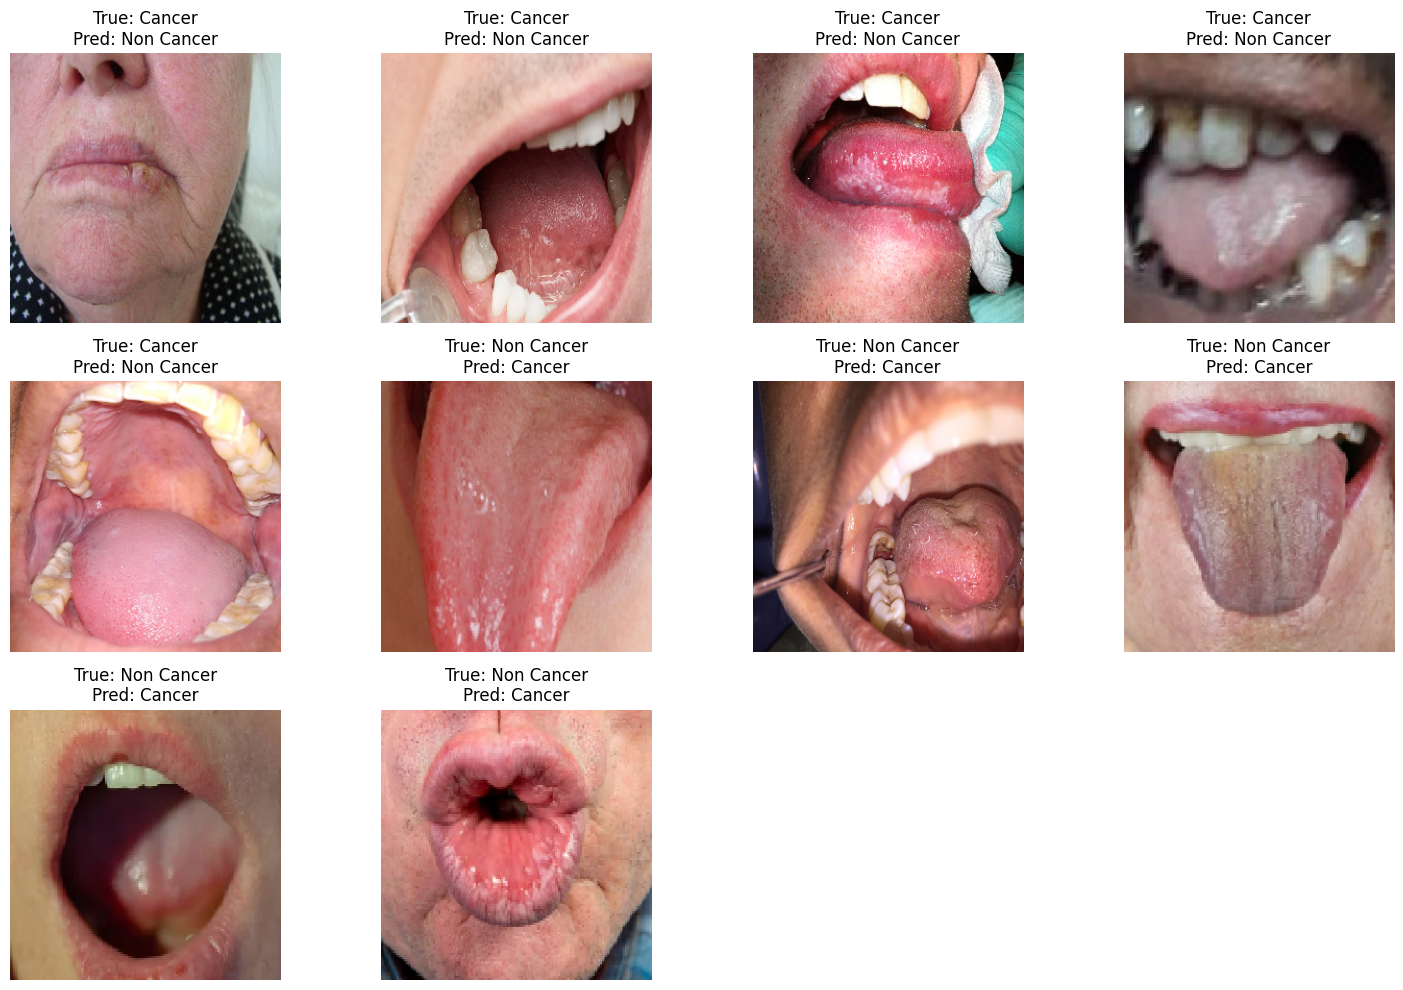

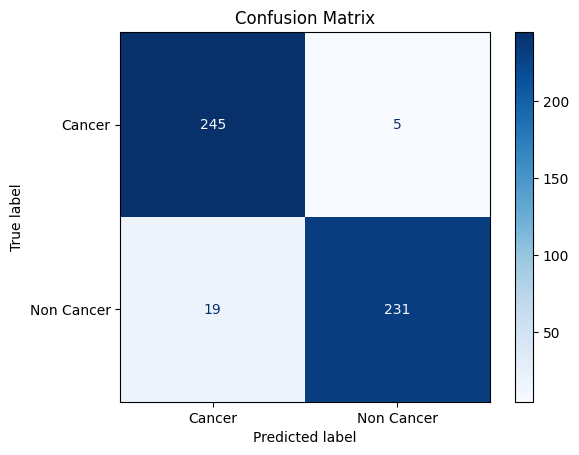

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.93      0.98      0.95       250
  Non Cancer       0.98      0.92      0.95       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



FileNotFoundError: [Errno 2] No such file or directory: 'D:/DL Project/misclassified_images/image_0.png'

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to analyze misclassifications and generate classification report
def analyze_misclassifications(model, data_path):
    new_images, new_labels = load_data(data_path)
    predictions = model.predict(new_images)
    predicted_classes = (predictions > 0.5).astype(int)

    # Identify misclassified images
    misclassified_indices = np.where(predicted_classes.flatten() != new_labels.flatten())[0]

    # Display misclassified images
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(misclassified_indices[:10]):  # Display first 10 misclassified images
        plt.subplot(3, 4, i + 1)
        plt.imshow(new_images[idx].astype('uint8'))
        plt.axis('off')
        plt.title(f'True: {"Cancer" if new_labels[idx] == 0 else "Non Cancer"}\nPred: {"Cancer" if predicted_classes[idx][0] == 0 else "Non Cancer"}')

    plt.tight_layout()
    plt.show()

    # Generate and display confusion matrix
    cm = confusion_matrix(new_labels, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(new_labels, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Optionally, save misclassified images for retraining
    misclassified_images = new_images[misclassified_indices]
    misclassified_labels = new_labels[misclassified_indices]
    for i, idx in enumerate(misclassified_indices):
        # Save misclassified images to a specific directory for further analysis
        save_path = f"D:/DL Project/misclassified_images/image_{i}.png"
        plt.imsave(save_path, new_images[idx].astype('uint8'))
        print(f"Saved misclassified image: {save_path}")

# Call the function to analyze misclassifications
analyze_misclassifications(model_EfficientNetB2, "test")


d:\python\envs\ai\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Accuracy: 0.9620


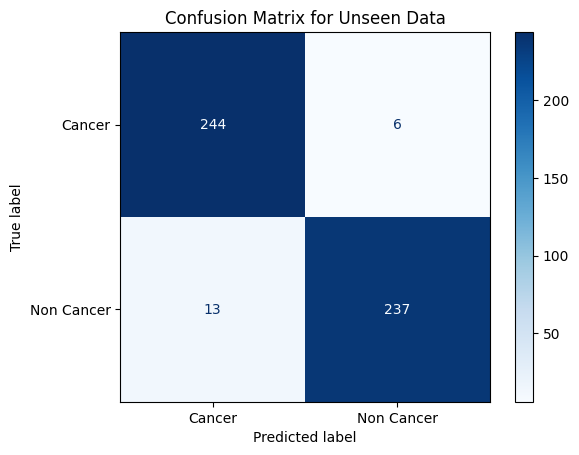

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.95      0.98      0.96       250
  Non Cancer       0.98      0.95      0.96       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



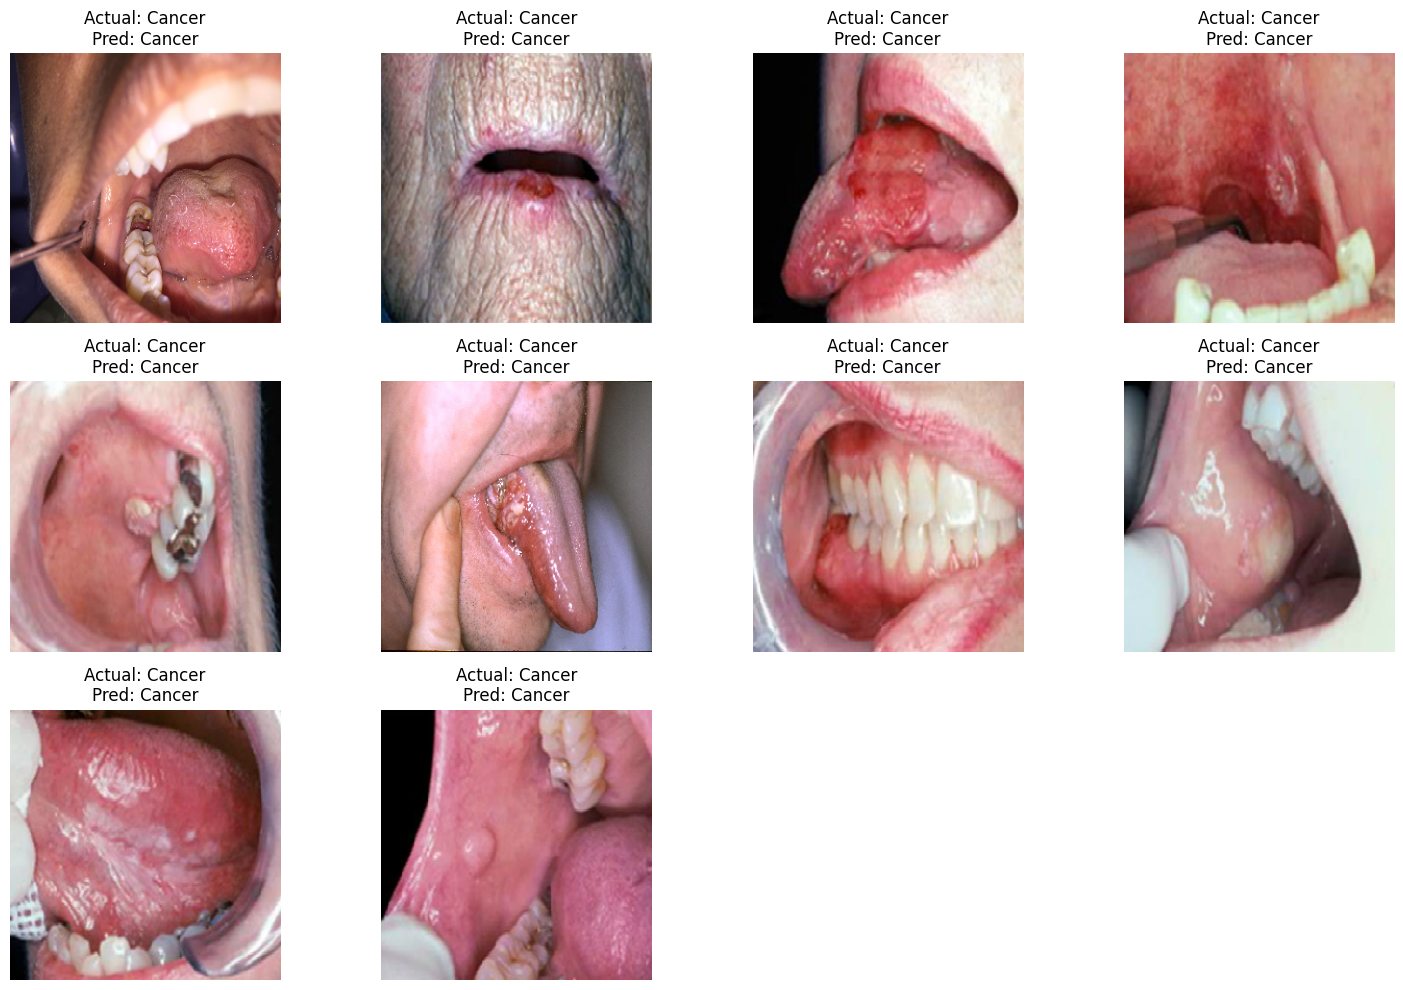

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to evaluate the model on unseen images
def evaluate_model(model, test_data_path):
    # Load new unseen data
    X_test, y_test = load_data(test_data_path)
    
    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = (predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = np.mean(predicted_classes.flatten() == y_test.flatten())
    print(f'Accuracy: {accuracy:.4f}')

    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_test, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Unseen Data')
    plt.show()

    report = classification_report(y_test, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Visualize some predictions
    num_images = 10  # Adjust the number of images to display
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[i].astype('uint8'))
        plt.axis('off')
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if predicted_classes[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPred: {predicted}')

    plt.tight_layout()
    plt.show()

# Call the function to evaluate the model on unseen images
evaluate_model(model_EfficientNetB2, "D:/DL Project/test")  # Specify the path to the unseen test data


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


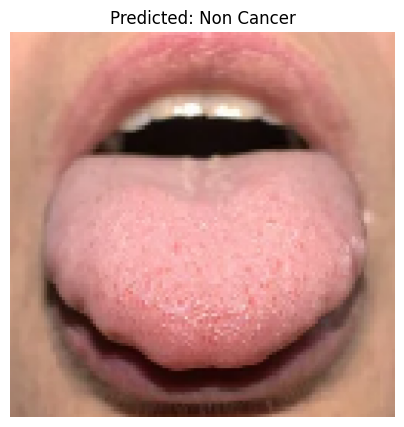

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load a single image
def load_single_image(image_path):
    image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

# Function to evaluate the model on a single image
def evaluate_single_image(model, image_path, true_label=None):
    # Load the image
    image = load_single_image(image_path)
    
    # Make predictions
    prediction = model.predict(image)
    predicted_class = 0 if prediction < 0.5 else 1  # 0 for Cancer, 1 for Non Cancer
    
    # Map predictions to labels
    predicted_label = 'Cancer' if predicted_class == 0 else 'Non Cancer'
    
    # Display the image with the prediction
    plt.figure(figsize=(5, 5))
    plt.imshow(image[0].astype('uint8'))  # Remove batch dimension for visualization
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}', fontsize=12)
    plt.show()

# Example usage with the model
# Provide the correct image path and true label (0 for Cancer, 1 for Non Cancer) if available
evaluate_single_image(model_EfficientNetB2, "test/NON CANCER/010.jpeg", true_label=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


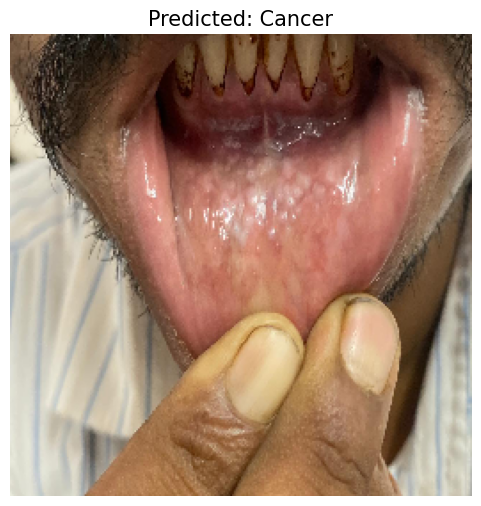

Predicted label for the image: Cancer


In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess a single image
def load_single_image(image_path):
    image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
    image_array = img_to_array(image)
    return np.expand_dims(image_array, axis=0)  # Expand dimensions to match model input shape

# Function to evaluate the model on a single image
def evaluate_single_image(model, image_path):
    # Load the single image
    X_single = load_single_image(image_path)
    
    # Make prediction
    prediction = model.predict(X_single)
    predicted_class = (prediction > 0.5).astype(int)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(X_single[0].astype('uint8'))
    plt.axis('off')
    
    # Display the prediction
    predicted_label = "Cancer" if predicted_class[0][0] == 0 else "Non Cancer"
    plt.title(f'Predicted: {predicted_label}', fontsize=15)
    plt.show()

    # Return the predicted label for further use if needed
    return predicted_label

# Specify the path to the single image
image_path = "test/CANCER/078.jpeg"  # Update the path to your image

# Call the function to evaluate the single image
predicted_label = evaluate_single_image(model_EfficientNetB2, image_path)
print(f'Predicted label for the image: {predicted_label}')


In [28]:
# Save the trained model
model_EfficientNetB2.save('efficientNetB2_oral_cancer_model.keras')


d:\python\envs\ai\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
Accuracy: 0.8540


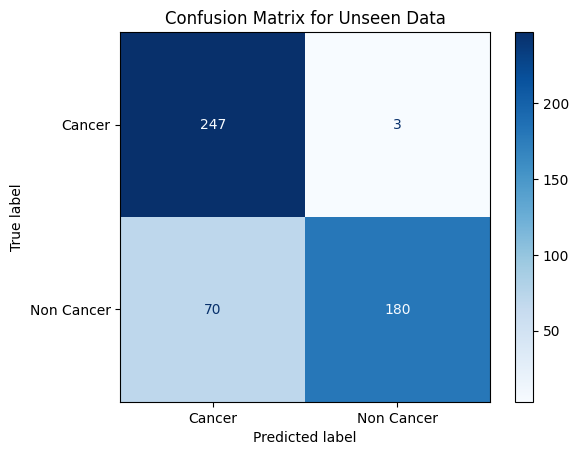

Classification Report:
               precision    recall  f1-score   support

      Cancer       0.78      0.99      0.87       250
  Non Cancer       0.98      0.72      0.83       250

    accuracy                           0.85       500
   macro avg       0.88      0.85      0.85       500
weighted avg       0.88      0.85      0.85       500



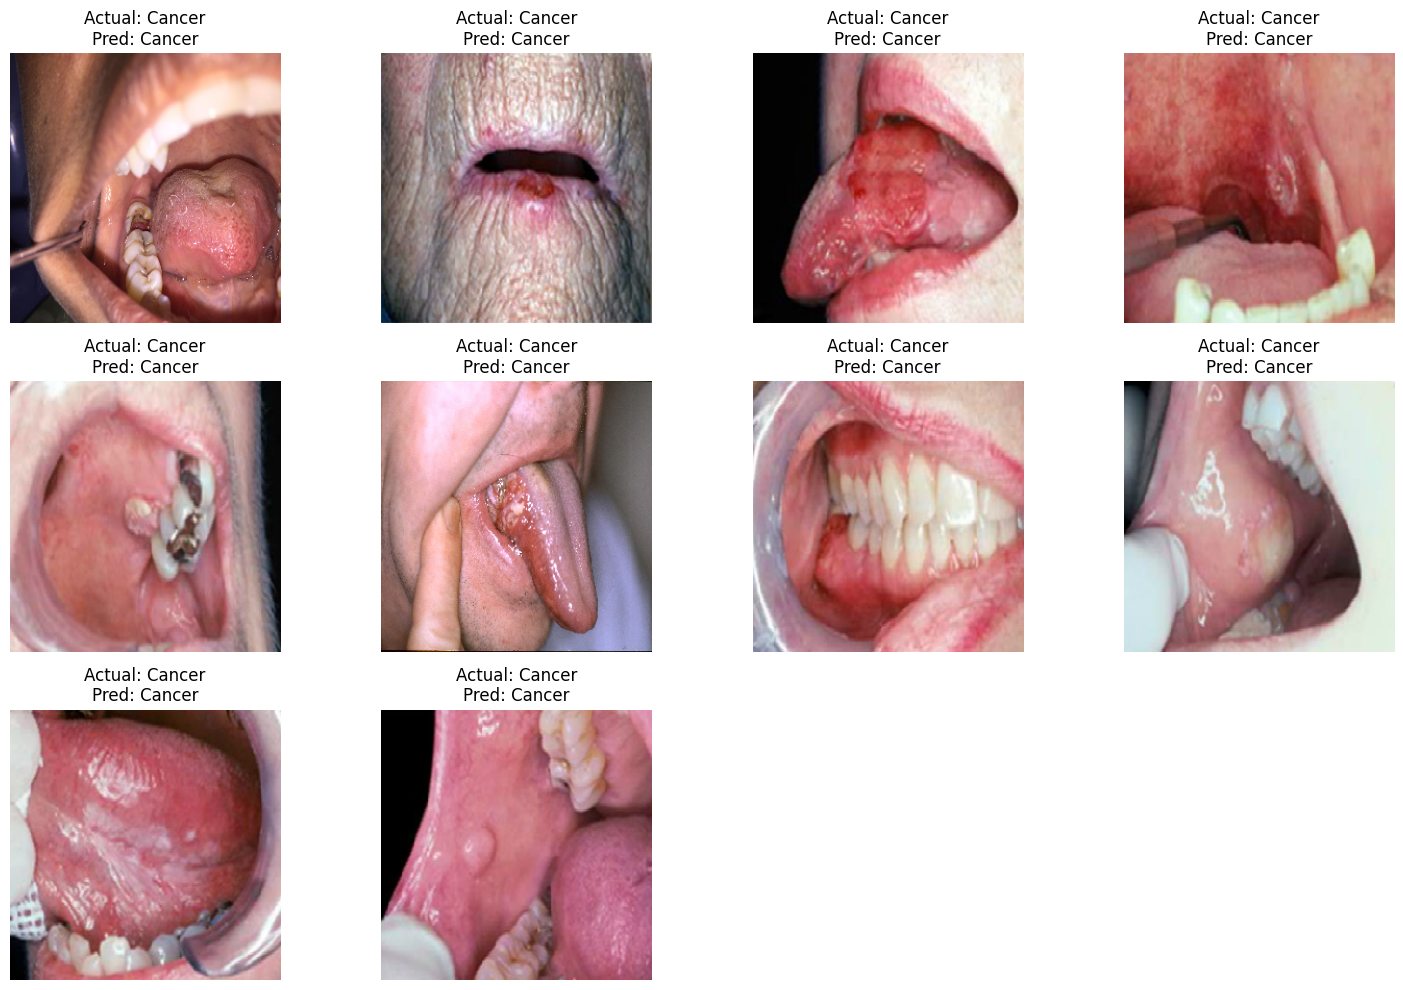

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


# Load the saved ResNet model
model_path = "./prediction/efficientNetB2_oral_cancer_model.keras"  # Update with your model's path
model_ResNet50 = load_model(model_path)
# Function to load images from a directory
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to evaluate the model on unseen images
def evaluate_model(model, test_data_path):
    # Load new unseen data
    X_test, y_test = load_data(test_data_path)
    
    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = (predictions > 0.5).astype(int)

    # Calculate metrics
    accuracy = np.mean(predicted_classes.flatten() == y_test.flatten())
    print(f'Accuracy: {accuracy:.4f}')

    # Generate confusion matrix and classification report
    cm = confusion_matrix(y_test, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cancer", "Non Cancer"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix for Unseen Data')
    plt.show()

    report = classification_report(y_test, predicted_classes, target_names=["Cancer", "Non Cancer"])
    print("Classification Report:\n", report)

    # Visualize some predictions
    num_images = 10  # Adjust the number of images to display
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        plt.imshow(X_test[i].astype('uint8'))
        plt.axis('off')
        actual = 'Cancer' if y_test[i] == 0 else 'Non Cancer'
        predicted = 'Cancer' if predicted_classes[i][0] == 0 else 'Non Cancer'
        plt.title(f'Actual: {actual}\nPred: {predicted}')

    plt.tight_layout()
    plt.show()

# Call the function to evaluate the model on unseen images
evaluate_model(model_ResNet50, "D:/DL Project/test")  # Specify the path to the unseen test data
